# Showcase for the virtual receptor

### Reading-in the libraries to be used. 

In [1]:
import random
import time

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE
import sklearn
from packaging.version import Version

from scipy.stats import pearsonr as cor
from scipy.stats import spearmanr as spear


import torch
#import torch.nn as nn


import VReceptor

from LSTM_model import LSTM, NN

#### For this notebook any peptide will do. Here I use hPrRP. 

In [2]:
peptide='SRTHRHSMEIRTPDINPAWYASRGIRPVGRF'
print ('The peptide is {} amino acids long.'.format(len(peptide)))



The peptide is 31 amino acids long.


This defines the pharmacophore model. While in reality the important amino acids are at the C-terminal (31), here I added a 2nd region at position 16. The counting for the parameter is zero-based 31->30, 16->15. The parameter list is constructed like:  [number_of_gausssians, offset, parameter_first_gaussian x 3, paramenter_second_gaussian x 3]

Gaussian Parameter: mean, std, height

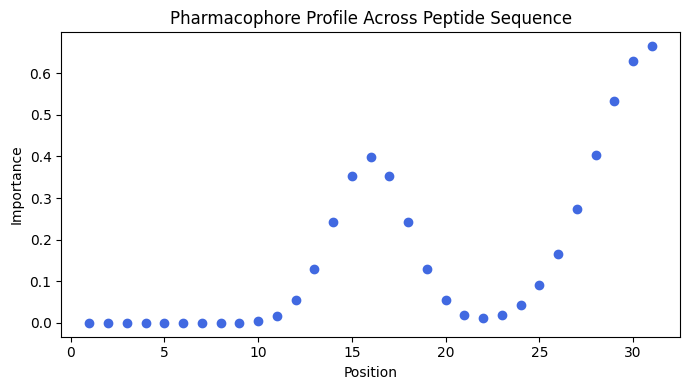

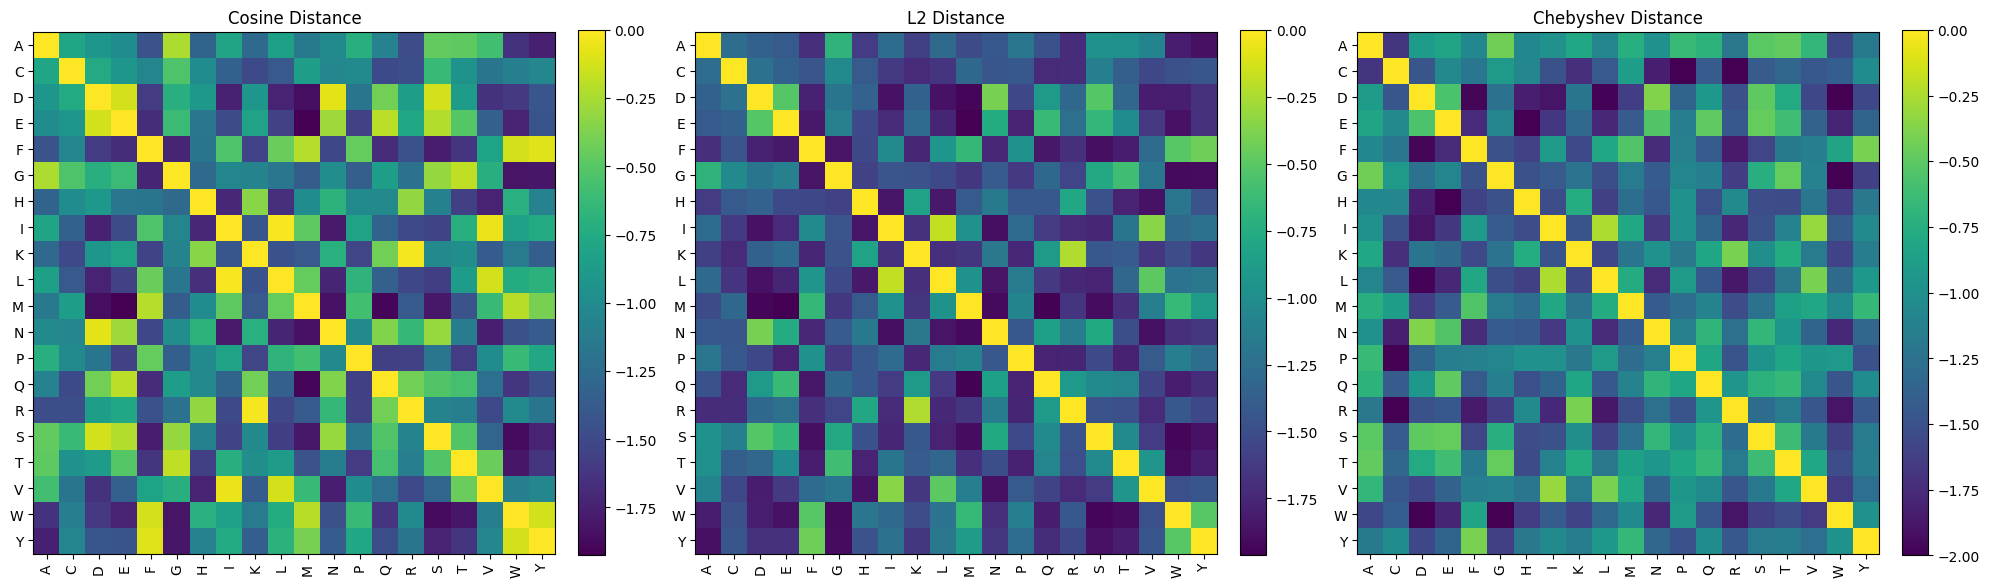

In [4]:
parameter = [2, 0, 30, 3, 5, 15, 2, 2]

x = np.arange(1, 32)  # Positions 1 to 31 (inclusive)
y = VReceptor.func(x - 1, *parameter)  # Shift x by -1 if func expects 0-based positions

plt.figure(figsize=(7, 4))
plt.scatter(x, y, color='royalblue')
plt.xlabel('Position')
plt.ylabel('Importance')
plt.title('Pharmacophore Profile Across Peptide Sequence')
#plt.xticks(x)
plt.tight_layout()
plt.savefig('Pharmacophore_Profile.jpg', dpi=300)
plt.show()

cosine_distance = VReceptor.cosine_dist(VReceptor.aa)
L2_distance = VReceptor.L2_dist(VReceptor.aa)
chebyshev_distance = VReceptor.chebyshev_dist(VReceptor.aa)

# Convert distance dictionaries to matrices for plotting
aa_list = VReceptor.aa
cosine_matrix = np.array([[cosine_distance[a1][a2] for a2 in aa_list] for a1 in aa_list])
L2_matrix = np.array([[L2_distance[a1][a2] for a2 in aa_list] for a1 in aa_list])
chebyshev_matrix = np.array([[chebyshev_distance[a1][a2] for a2 in aa_list] for a1 in aa_list])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

im1 = axes[0].imshow(cosine_matrix, cmap='viridis')
axes[0].set_title('Cosine Distance')
axes[0].set_xticks(range(len(aa_list)))
axes[0].set_yticks(range(len(aa_list)))
axes[0].set_xticklabels(aa_list)
axes[0].set_yticklabels(aa_list)
plt.setp(axes[0].get_xticklabels(), rotation=90)
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(L2_matrix, cmap='viridis')
axes[1].set_title('L2 Distance')
axes[1].set_xticks(range(len(aa_list)))
axes[1].set_yticks(range(len(aa_list)))
axes[1].set_xticklabels(aa_list)
axes[1].set_yticklabels(aa_list)
plt.setp(axes[1].get_xticklabels(), rotation=90)
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(chebyshev_matrix, cmap='viridis')
axes[2].set_title('Chebyshev Distance')
axes[2].set_xticks(range(len(aa_list)))
axes[2].set_yticks(range(len(aa_list)))
axes[2].set_xticklabels(aa_list)
axes[2].set_yticklabels(aa_list)
plt.setp(axes[2].get_xticklabels(), rotation=90)
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('Amino_Acid_distances.jpg', dpi=300)
plt.show()

An instance of the receptor is created using the peptide string and the parameter list. Here I also screened the reference peptide 10000 times with a standard deviation (noise) of 0.1. All virtual assay results are relative to the reference peptide on a log scale.

In [6]:
#receptor = VReceptor.vreceptor(peptide, *parameter, seed = 42, func = VReceptor.func, aa = VReceptor.aa, aa_norm = VReceptor.cosine_dist)

#receptor = VReceptor.vreceptor(peptide, *parameter, seed = 42, func = VReceptor.func, aa = VReceptor.aa, aa_norm = VReceptor.chebyshev_dist)
receptor = VReceptor.vreceptor(peptide, *parameter, func = VReceptor.func, aa = VReceptor.aa, aa_norm = VReceptor.L2_dist)

In [7]:
df=receptor.virtual_assay([peptide]*10000, noise = 0.1)


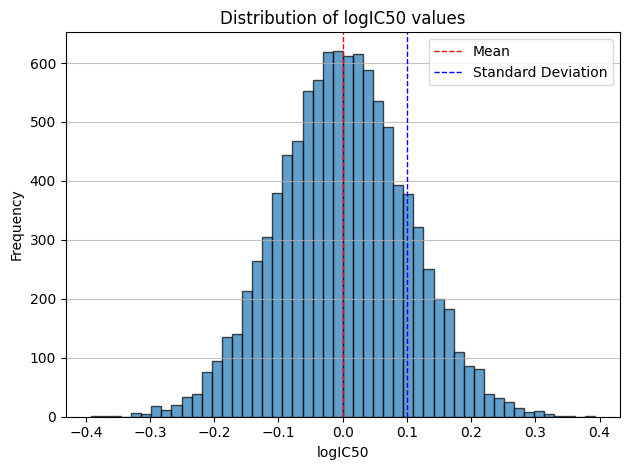

Mean: -0.000
SD: 0.100


In [8]:

#sns.histplot(df['logIC50'])
plt.hist(df['logIC50'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('logIC50')
plt.ylabel('Frequency')
plt.title('Distribution of logIC50 values')
plt.grid(axis='y', alpha=0.75)
plt.axvline(df['logIC50'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(df['logIC50'].std(), color='blue', linestyle='dashed', linewidth=1, label='Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

print ('Mean: {:.3f}'.format(df['logIC50'].mean()))

print ('SD: {:.3f}'.format(df['logIC50'].std()))

Here lists with all single, double, and triple mutations are generated. For this exercise the amino acid cysteine is included ().

In [9]:
g_1 = VReceptor.peptide_generator(peptide, 1)
g_2 = VReceptor.peptide_generator(peptide, 2)
g_3 = VReceptor.peptide_generator(peptide, 3)


peptide_list_1 = [i for i in g_1]
peptide_list_2 = [i for i in g_2]
peptide_list_3 = [i for i in g_3]

print ('There are {} single point mutations!'.format(len(peptide_list_1)))
print ('There are {} double mutations!'.format(len(peptide_list_2)))
print ('There are {} triple mutations!'.format(len(peptide_list_3)))

There are 589 single point mutations!
There are 167865 double mutations!
There are 30831205 triple mutations!


Seed set so the results can be reproduced. The trained model, using either 589 single point mutations or 589 random triple mutations, will be tested on the test set with 200 peptides. The next line tests if there is an overlapp of train and test set.

In [10]:
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)

test_set = random.sample(peptide_list_3, 200)


train_set_random = random.sample(peptide_list_3, len(peptide_list_1))
train_set_scan = peptide_list_1

In [11]:
print ('The random train set contains {} peptides also contained in the test set.'
       .format(len([i for i in train_set_random if i in test_set])))

The random train set contains 0 peptides also contained in the test set.


In the cell below the peptide lists are virtual screened on the receptor defined above and encoded and formated for training and testing.

In [12]:
aa_ = [VReceptor.aa for i in range(len(peptide))]
if Version(sklearn.__version__) > Version('1.1.2'):
    enco = OneHotEncoder(sparse_output = False, categories=aa_)
else:
    enco = OneHotEncoder(sparse = False, categories=aa_)
train_df_random = receptor.virtual_assay(train_set_random, noise=0.1)
train_df_scan = receptor.virtual_assay(train_set_scan, noise=0.1)
test_df_set = receptor.virtual_assay(test_set, noise=0.1)

X_train_random = np.array([list(i) for i in train_df_random['Sequence']])
X_train_random = enco.fit_transform(X_train_random)
X_train_random = X_train_random.reshape(X_train_random.shape[0], int(X_train_random.shape[1]/len(VReceptor.aa)), len(VReceptor.aa))

X_train_scan = np.array([list(i) for i in train_df_scan['Sequence']])
X_train_scan = enco.transform(X_train_scan)
X_train_scan = X_train_scan.reshape(X_train_scan.shape[0], int(X_train_scan.shape[1]/len(VReceptor.aa)), len(VReceptor.aa))

X_test = np.array([list(i) for i in test_df_set['Sequence']])
X_test = enco.transform(X_test)
X_test = X_test.reshape(X_test.shape[0], int(X_test.shape[1]/len(VReceptor.aa)), len(VReceptor.aa))

y_train_random = np.array(train_df_random['logIC50']).reshape(-1,1)

y_train_scan = np.array(train_df_scan['logIC50']).reshape(-1,1)

y_test = np.array(test_df_set['logIC50']).reshape(-1,1)


print (X_train_random.shape)
print (y_train_random.shape)

print (X_train_scan.shape)
print (y_train_scan.shape)

print (X_test.shape)
print (y_test.shape)

GPU = torch.cuda.is_available() 
print ('Cuda is available: ',GPU)


    
    

(589, 31, 20)
(589, 1)
(589, 31, 20)
(589, 1)
(200, 31, 20)
(200, 1)
Cuda is available:  True


Two LSTM models are created for training with the random train set containing triple mutations or training with single mutations.

In [13]:
model_random = NN(LSTM(X_train_random.shape[2], y_train_random.shape[1]), GPU=GPU)
model_scan = NN(LSTM(X_train_scan.shape[2], y_train_scan.shape[1]), GPU=GPU)

In the two cells below the models are trained using the same standard hyper parameter.

In [14]:
model_random.fit(X_train_random, y_train_random)

Epoch: 100	Time since start:       2.21s	Train loss: 0.067
Epoch: 200	Time since start:       4.22s	Train loss: 0.038
Epoch: 300	Time since start:       6.24s	Train loss: 0.026
Epoch: 400	Time since start:       8.26s	Train loss: 0.019
Epoch: 500	Time since start:      10.31s	Train loss: 0.016
Epoch: 600	Time since start:      12.37s	Train loss: 0.015
Epoch: 700	Time since start:      14.42s	Train loss: 0.013
Epoch: 800	Time since start:      16.44s	Train loss: 0.017
Epoch: 900	Time since start:      18.45s	Train loss: 0.014
Epoch: 1000	Time since start:      20.50s	Train loss: 0.013


In [15]:
model_scan.fit(X_train_scan, y_train_scan)

Epoch: 100	Time since start:       2.03s	Train loss: 0.035
Epoch: 200	Time since start:       4.04s	Train loss: 0.031
Epoch: 300	Time since start:       6.03s	Train loss: 0.028
Epoch: 400	Time since start:       8.07s	Train loss: 0.027
Epoch: 500	Time since start:      10.11s	Train loss: 0.027
Epoch: 600	Time since start:      12.12s	Train loss: 0.025
Epoch: 700	Time since start:      14.14s	Train loss: 0.023
Epoch: 800	Time since start:      16.15s	Train loss: 0.021
Epoch: 900	Time since start:      18.16s	Train loss: 0.020
Epoch: 1000	Time since start:      20.16s	Train loss: 0.019


And now the evaluations using the test set and some plotting.

In [16]:

y_train_pre = model_random.predict(X_train_random)
y_test_pre = model_random.predict(X_test)


mse_train_random = MSE(y_train_pre,y_train_random)
mse_test_random = MSE(y_test_pre,y_test)

print (mse_train_random, mse_test_random)

0.010005268159638465 0.022899727548458575


In [17]:

y_train_pre = model_scan.predict(X_train_scan)
y_test_pre = model_scan.predict(X_test)


mse_train_scan = MSE(y_train_pre,y_train_scan)
mse_test_scan = MSE(y_test_pre,y_test)

print (mse_train_scan, mse_test_scan)

0.02350264232424661 0.1401884249380327


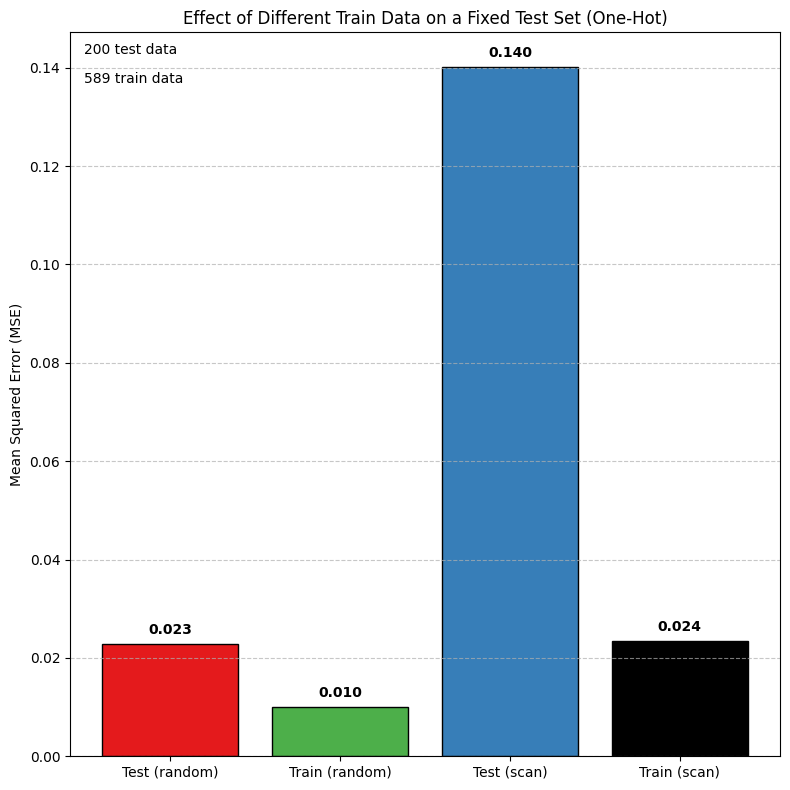

In [18]:
labels = ['Test (random)', 'Train (random)', 'Test (scan)', 'Train (scan)']
mses = [mse_test_random, mse_train_random, mse_test_scan, mse_train_scan]
colors = ['#e41a1c', '#4daf4a', '#377eb8', '#000000']  

fig, ax = plt.subplots(figsize=(8, 8))

bars = ax.bar(labels, mses, color=colors, edgecolor='black')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Effect of Different Train Data on a Fixed Test Set (One-Hot)')
ax.text(0.02, 0.93, '589 train data', transform=ax.transAxes, fontsize=10)
ax.text(0.02, 0.97, '200 test data', transform=ax.transAxes, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('MSE_Comparison.jpg', dpi=300)
plt.show()